## Logistic and Random Forest Models for Admission to UC
Barak Krakauer, June 2016

In [109]:
# Imports and display settings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, neighbors, ensemble, cross_validation, grid_search

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

## Importing and Cleaning Data

In [48]:
def read_admissions():
    return pd.read_table('admit.csv', encoding='utf-16')

def read_income():
    return pd.read_csv('county_income.csv', names = ["County", "Income"])

def read_gpas():
    return pd.read_table('frgpabyyear.csv', encoding='utf-16')

df = read_admissions()
income = read_income()
income = income.set_index("County")
gpas = read_gpas()


In [51]:
# The df will list entries without students as NaN. Set them to zero instead.

df = df.fillna(0)

# Tidy the names of the cols

df.drop(["Calculation1"], axis = 1, inplace=True)
df.rename(columns = {'All': 'Students', 'County/State/ Territory' : 'County', 'American Indian': 'AmIndian', \
                            'Hispanic/ Latino' : 'Hispanic', 'Domestic Unknown' : 'Unknown',  'African American' : 'Black',\
                             'Inter- national': 'International'}, inplace=True)


In [52]:
# Add the county-level income data to the df

df["Income"] = df.County
df.Income = df.Income.apply(lambda x: income.at[x, "Income"])

#Strip away the dollar sign, make it an int
df.Income = df.Income.str.replace('$','')
df.Income = df.Income.str.replace(',','')
df.Income = df.Income.apply(lambda x: int(x))

In [53]:
# The admissions df will have data on applicants and admitted students run together, so we'll separate them out.
# (We also could have set this up as a multi-index DF)

applicants = df[df["Unnamed: 4"] == "Applicants"].reset_index()
applicants.drop("index", axis = 1, inplace=True)
admitted = df[df["Unnamed: 4"] == "Admits"].reset_index()
admitted.drop("index", axis=1, inplace=True)

applicants.drop(["Unnamed: 4"], axis = 1, inplace=True)
admitted.drop(["Unnamed: 4"], axis = 1, inplace=True)

In [54]:
# Add the GPA data to the relevant df (that is, the average applicant GPA to applicants and admitted GPA to admitted)

applicants = pd.merge(applicants, gpas[["School Name", "City", "App GPA"]], on=["School Name", "City"])
admitted = pd.merge(admitted, gpas[["School Name", "City", "Adm GPA"]], on=["School Name", "City"])

## Generate simulated student-level data from the high school-level data

In [56]:
# Note that this cell takes a minute to run...

def simulate_hs(admits, admgpa, schooln, city, county, applicants, afram, amind, hispanic, asian, white, unk, intl, \
                income, appgpa):
    df = pd.DataFrame({'School Name' : schooln, 'City' : city, 'County' : county, 'Applicants' : 1, 'Black' : 0 \
                       , 'AmIndian' : 0, 'Hispanic' : 0, 'Asian' : 0, 'White' : 0, 'Unknown' : 0, 'International' \
                       : 0, 'Income' : income, 'Student GPA' : 0, 'Admitted' : 0}, index=range(int(applicants)))
    

    #We'll have to put in a default GPA, in case what we're passed 0 or NaN

    # This produces somewhat believable GPAs in a normal distribution around the avg GPA.    
    gpas = list(np.random.randn(int(applicants)) / 3 + appgpa)
    
    # Sort list of GPAs and find the GPA cutoff for admission.
    cutoff = sorted(gpas)[0 - admits]
    
    # Now
    for i in range(int(applicants)):
        if afram > 0:
            df.loc[i, "Black"] = 1
            afram -= 1
        elif amind > 0:
            df.loc[i, "AmIndian"] = 1
            amind -= 1
        elif hispanic > 0:
            df.loc[i, "Hispanic"] = 1
            hispanic -= 1
        elif asian > 0:
            df.loc[i, "Asian"] = 1
            asian -= 1
        elif white > 0:
            df.loc[i, "White"] = 1
            white -= 1
        elif intl > 0:
            df.loc[i, "International"] = 1
            intl -= 1
        else:
            df.loc[i, "Unknown"] = 1
            unk -= 1 # technically unecessary, but may be nice for debugging
        gpa = gpas.pop()
        df.loc[i, "Student GPA"] = gpa
        if gpa >= cutoff:
            df.loc[i, "Admitted"] = 1
        
    # Note that we've essentially randomized the ethnicities of those admitted from the sample!
    return df

students = pd.DataFrame({})

for i in range(len(applicants)):
    students = students.append(simulate_hs(int(admitted.loc[i, "Students"]), admitted.loc[i, "Adm GPA"], *applicants.loc[i]))

## Data Exploration & Visualization

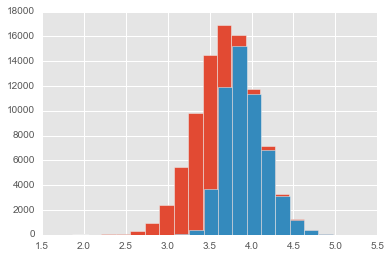

In [58]:
students["Student GPA"].hist(bins = 20)
students[students.Admitted == 1]["Student GPA"].hist(bins = 20)

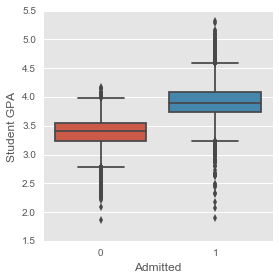

In [59]:
sns.factorplot(x = 'Admitted',
    y = 'Student GPA',
    data = students,
    kind = 'box')

How close is our estimated student-level data to the actual data, with respect to ethnicity makeup of the incoming class?

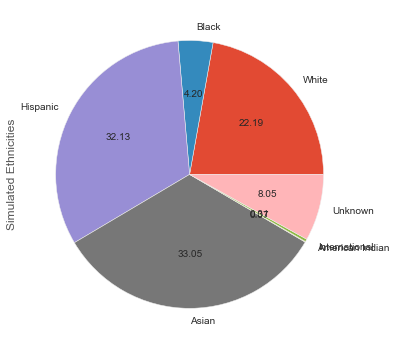

In [70]:
w = len(students[(students.Admitted == 1) & (students.White == 1)])
b = len(students[(students.Admitted == 1) & (students.Black == 1)])
h = len(students[(students.Admitted == 1) & (students.Hispanic == 1)])
a = len(students[(students.Admitted == 1) & (students.Asian == 1)])
i = len(students[(students.Admitted == 1) & (students.AmIndian == 1)])
o = len(students[(students.Admitted == 1) & (students.International == 1)])
u = len(students[(students.Admitted == 1) & (students.Unknown == 1)])

ethn = pd.Series([w, b, h, a, i, o, u], index = ["White", "Black", "Hispanic", "Asian", "American Indian", "International",\
                                                 "Unknown"], name = "Simulated Ethnicities")
ethn.plot(kind='pie', autopct='%.2f', figsize = (6, 6))

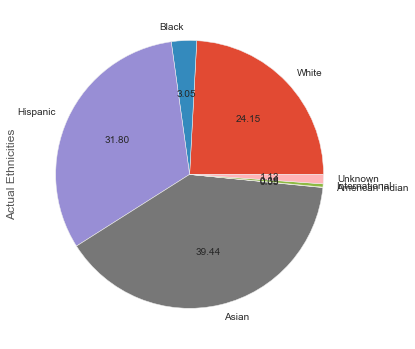

In [71]:
w = sum(admitted.White)
b = sum(admitted.Black)
h = sum(admitted.Hispanic)
a = sum(admitted.Asian)
i = sum(admitted.AmIndian)
o = sum(admitted.International)
u = sum(admitted.Unknown)

ethn_real = pd.Series([w, b, h, a, i, o, u], index = ["White", "Black", "Hispanic", "Asian", "American Indian", \ 
                                                      "International", "Unknown"], name = "Actual Ethnicities")
ethn_real.plot(kind='pie', autopct='%.2f', figsize = (6, 6))

Conclusion: The simulated data looks pretty good on ethnicities, at least on first pass. All categories are within 2% of the actual incoming class, with the exception of Asian students (which the model under-represents by about 6%) and "Unknown", which the model over-represents by about 7%).

## To what degree do demographic factors affect admissions rates?

In [87]:
dfpcts = applicants[ ["School Name", "City", "County", "Students", "Income"] ]
dfpcts.loc[:,'Admits'] = admitted.Students

dfpcts.loc[:,"PctWhite"] = applicants.White / applicants.Students
dfpcts.loc[:,"PctAfrAm"] = applicants.Black / dfpcts.Students
dfpcts.loc[:,"PctLatino"] = applicants.Hispanic / applicants.Students
dfpcts.loc[:,"PctAsian"] = applicants.Asian / applicants.Students

dfpcts.loc[:,'Percent'] = (admitted.Students / applicants.Students)

,School Name,City,County,Students,Income,Admits,PctWhite,PctAfrAm,PctLatino,PctAsian
0,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,76.0,51017,42.0,0.000000,0.065789,0.842105,0.065789
1,ABRAHAM LINCOLN HIGH SCHOOL,Los Angeles,Los Angeles,82.0,52239,49.0,0.000000,0.000000,0.365854,0.597561
2,ABRAHAM LINCOLN HIGH SCHOOL,San Francisco,San Francisco,184.0,69354,100.0,0.000000,0.000000,0.108696,0.842391
3,ABRAHAM LINCOLN HIGH SCHOOL,San Jose,Santa Clara,78.0,84741,45.0,0.294872,0.000000,0.474359,0.141026
4,ACAD FOR ACADEMIC EXCELLENCE,Apple Valley,San Bernardino,23.0,51017,8.0,0.434783,0.000000,0.304348,0.217391


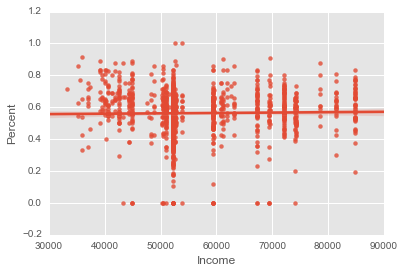

In [89]:
sns.regplot(x="Income", y="Percent", data=dfpcts)

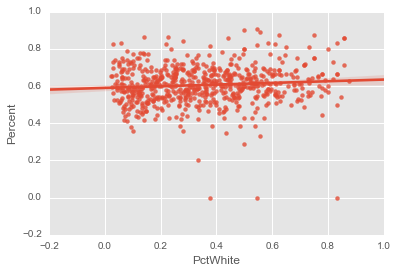

In [98]:
sns.regplot(x="PctWhite", y="Percent", data=dfpcts[dfpcts.PctWhite > 0])

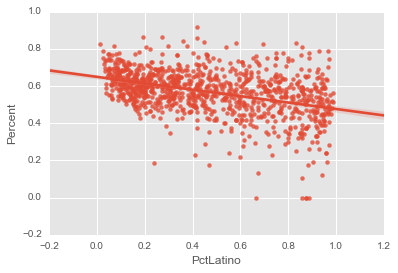

In [93]:
sns.regplot(x="PctLatino", y="Percent", data=dfpcts[dfpcts.PctLatino > 0])

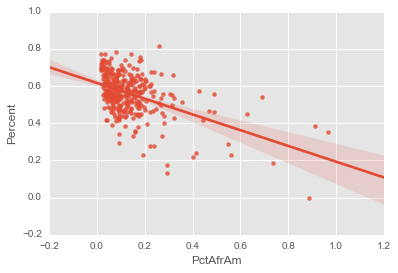

In [96]:
sns.regplot(x="PctAfrAm", y="Percent", data=dfpcts[dfpcts.PctAfrAm > 0])

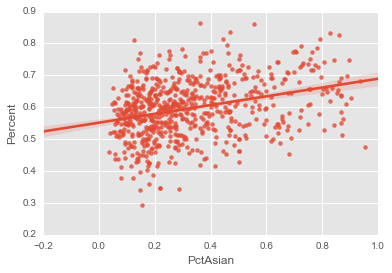

In [101]:
sns.regplot(x="PctAsian", y="Percent", data=dfpcts[dfpcts.PctAsian > 0])

Conclusion: The greater the percentage of Asian students (and, to a lesser degree, white students), the greater the acceptance rate of the high school. High schools with more Hispanic and African American students have lower acceptance rates. County income does not seem to be significant.

## Building Models

In [102]:
# First, separate the data into training and testing sets.

train_df = students.sample(frac = .6, random_state = 0)
test_df = students.drop(train_df.index)

In [103]:
# Setting the features of our model
# Note that we've left out the 'white' column; this is because we want one less dummy variable than the num of features.

train_X = train_df[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'International', 'Student GPA']]
train_y = train_df.Admitted
test_X = test_df[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'International', 'Student GPA']]
test_y = test_df.Admitted

## Model 1: Logistic Regression

In [104]:
logmodel = linear_model.LogisticRegression()
logmodel.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [105]:
# Score the model based on training data.
logmodel.score(train_X, train_y)

0.89655235954228008

In [106]:
# Score the model based on testing data.
logmodel.score(test_X, test_y)

0.8571428571428571

## Model 2: K Nearest Neighbors

In [110]:
knnmodel = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodel.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [111]:
cv = cross_validation.KFold(len(test_df), n_folds = 5)


In [113]:
# Find the best value for k

k_cv = 10 # 10-fold CV
k_nn = range(1, 20)

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn},
    cv = cross_validation.KFold(len(train_df), n_folds = k_cv)
)

gs.fit(train_X, train_y)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'Score': [score.mean_validation_score for score in gs.grid_scores_]})

In [114]:
score_df.sort_values("Score", ascending=False)

,Score,k
18,0.892241,19
17,0.891964,18
16,0.891835,17
14,0.891227,15
15,0.890748,16
...,...,...
5,0.881184,6
3,0.874422,4
2,0.874164,3
0,0.854926,1


In [116]:
knnmodel = neighbors.KNeighborsClassifier(n_neighbors = 18, weights = 'distance')
knnmodel.fit(train_X, train_y)
knnmodel.score(test_X, test_y)

0.8571428571428571

## Model 3: Random Forest

In [117]:
rfmodel = ensemble.RandomForestClassifier(n_estimators = 1000, oob_score = True)

rfmodel.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [118]:
rfmodel.oob_score_

0.85527649302548414

In [119]:
rfmodel.score(test_X, test_y)

0.8571428571428571